# Demand Forecasting

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Data Wrangling

In [2]:
df1=pd.read_csv('sales_data.csv')
df1.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [3]:
df1.shape

(76000, 16)

In [4]:
df=df1.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

In [6]:
df.describe(include='all')

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
count,76000,76000,76000,76000,76000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000,76000.000000,76000.000000,76000,76000.000000,76000.000000
unique,760,5,20,5,4,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,4,NaN,NaN
top,2024-01-30,S001,P0001,Groceries,North,NaN,NaN,NaN,NaN,NaN,Cloudy,NaN,NaN,Winter,NaN,NaN
freq,100,15200,3800,30400,30400,NaN,NaN,NaN,NaN,NaN,24360,NaN,NaN,21000,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,301.062842,88.827316,89.090645,67.726028,9.087039,NaN,0.328947,69.454029,NaN,0.200000,104.317158
std,NaN,NaN,NaN,NaN,NaN,226.510161,43.994525,162.404627,39.377899,7.475781,NaN,0.469834,40.943818,NaN,0.400003,46.964801
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.740000,0.000000,NaN,0.000000,4.290000,NaN,0.000000,4.000000
25%,NaN,NaN,NaN,NaN,NaN,136.000000,58.000000,0.000000,31.997500,5.000000,NaN,0.000000,32.620000,NaN,0.000000,71.000000
50%,NaN,NaN,NaN,NaN,NaN,227.000000,84.000000,0.000000,64.500000,10.000000,NaN,0.000000,65.700000,NaN,0.000000,100.000000
75%,NaN,NaN,NaN,NaN,NaN,408.000000,114.000000,121.000000,95.830000,10.000000,NaN,1.000000,97.932500,NaN,0.000000,133.000000


### NULL Values

In [7]:
for col in df.columns:
    print(f'{col}:{df[col].isna().sum()}')

Date:0
Store ID:0
Product ID:0
Category:0
Region:0
Inventory Level:0
Units Sold:0
Units Ordered:0
Price:0
Discount:0
Weather Condition:0
Promotion:0
Competitor Pricing:0
Seasonality:0
Epidemic:0
Demand:0


The dataset has no NULL values.

### Duplicates

In [8]:
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicate rows in the dataset.")


There are 0 duplicate rows in the dataset.


### Outliers

As the outlier constituted to approx 11-12% data. I expanded the range.

In [9]:
def outlier_detection(col):
    fq=df[col].quantile(0.25)
    tq=df[col].quantile(0.75)
    iqr=tq-fq
    med=df[col].median()
    lower_bound = med - (2 * iqr)
    upper_bound = med + (2 * iqr)
    outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f'{col}:{outlier_count}')
    return outlier_count

In [10]:
def combined_outlier_mask(df, col):
    median = df[col].median()
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = median - 2 * IQR
    upper = median + 2 * IQR
    return (df[col] >= lower) & (df[col] <= upper)

Inventory Level:3484


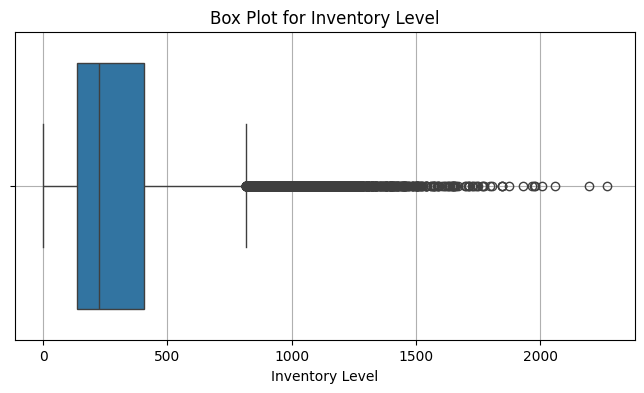

Units Sold:1533


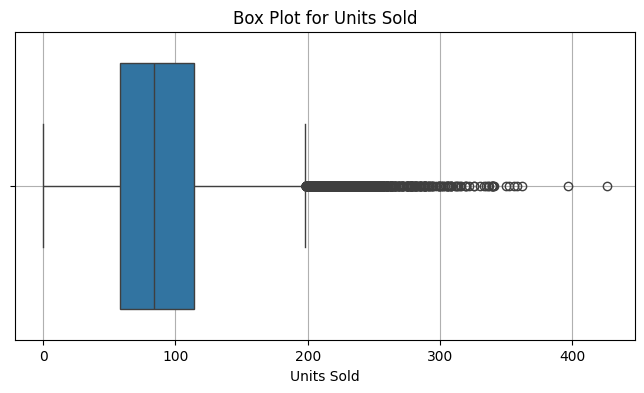

Demand:1059


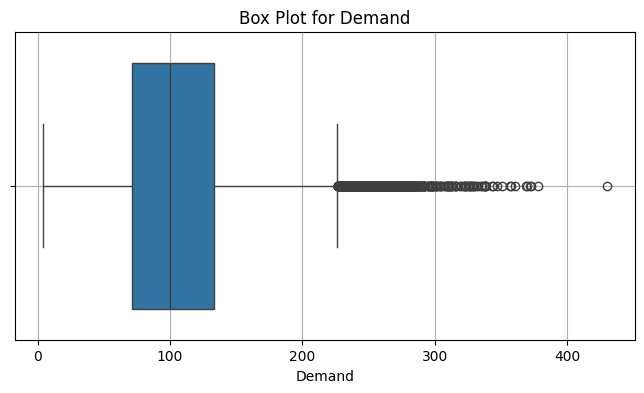

In [11]:
cols=['Inventory Level', 'Units Sold', 'Demand']
for col in cols:
    outlier_detection(col)
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot for {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()


In [12]:
mask = combined_outlier_mask(df, 'Inventory Level') \
     & combined_outlier_mask(df, 'Units Sold') \
     & combined_outlier_mask(df, 'Demand')

df= df[mask]
print(f"Removed {df.shape[0] - df.shape[0]} rows (combined outliers)")

Removed 0 rows (combined outliers)


## Exploratory Data Analysis

### Distribution of Demand

#### Across Stores

In [26]:
demand_by_store=df.groupby('Store ID')['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_store

,Store ID,Demand
3,S004,1362271
0,S001,1384846
2,S003,1423193
4,S005,1455384
1,S002,1461316


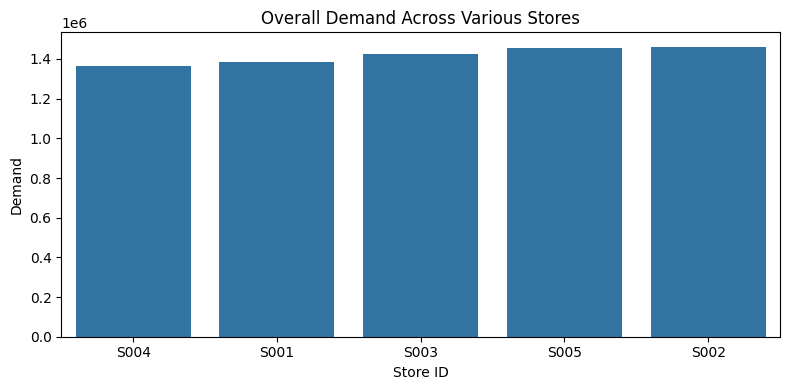

In [27]:
plt.figure(figsize=(8,4))
sns.barplot(data=demand_by_store,x='Store ID', y='Demand')
plt.title('Overall Demand Across Various Stores')
plt.tight_layout()
plt.show()

Store 2 has the highest demand of products while store 4 has least demand of products.

#### Across Categories

In [28]:
demand_by_category=df.groupby('Category')['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_category

,Category,Demand
1,Electronics,838965
4,Toys,944930
2,Furniture,995590
0,Clothing,1246765
3,Groceries,3060760


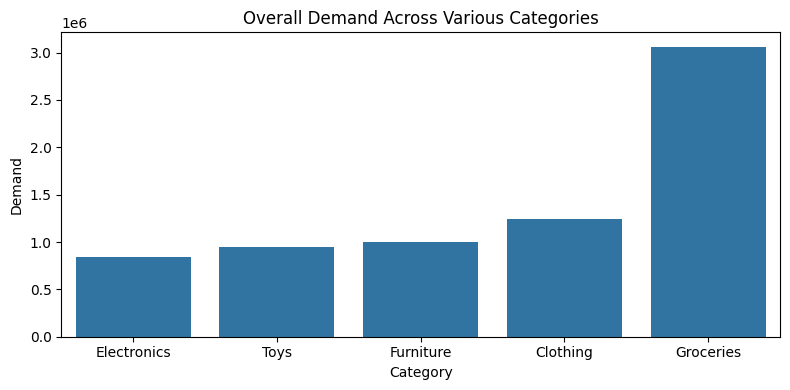

In [30]:
plt.figure(figsize=(8,4))
sns.barplot(data=demand_by_category,x='Category', y='Demand')
plt.title('Overall Demand Across Various Categories')
plt.tight_layout()
plt.show()

Groceries has significantly more demand than any other category of product.

#### Store wise Demand of Different Categories of Products

In [ ]:
demand_by_store_by_category=df.groupby(['Store ID','Category'])['Demand'].sum().reset_index()
demand_by_store_by_category.head(5)

,Store ID,Category,Demand
0,S001,Clothing,241781
1,S001,Electronics,210796
2,S001,Furniture,219486
3,S001,Groceries,438334
4,S001,Toys,274449


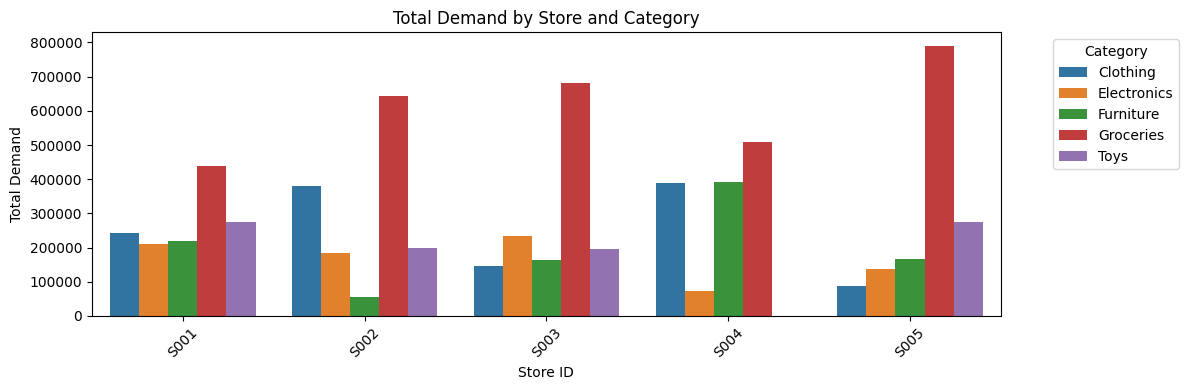

In [38]:
plt.figure(figsize=(12,4))
sns.barplot(data=demand_by_store_by_category,
            x='Store ID',
            y='Demand',
            hue='Category')

plt.title('Total Demand by Store and Category')
plt.xlabel('Store ID')
plt.ylabel('Total Demand')
plt.legend(title='Category',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
demand_by_store_by_category_by_product=df.groupby(['Store ID','Category','Product ID'])['Demand'].sum().reset_index()
demand_by_store_by_category_by_product.head(5)

,Store ID,Category,Product ID,Demand
0,S001,Clothing,P0002,88893
1,S001,Clothing,P0003,65333
2,S001,Clothing,P0009,87555
3,S001,Electronics,P0001,70127
4,S001,Electronics,P0004,69946


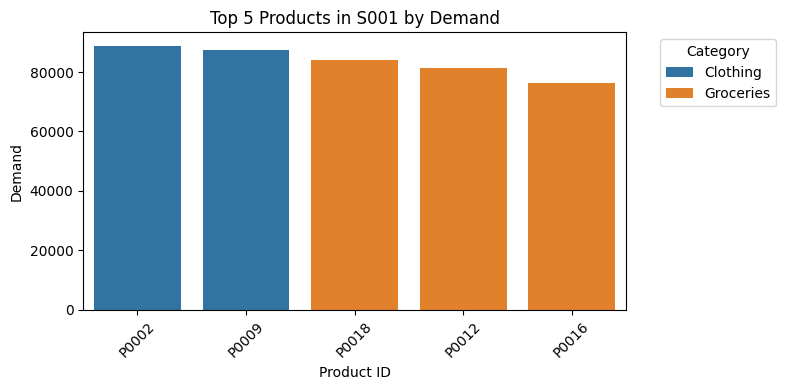

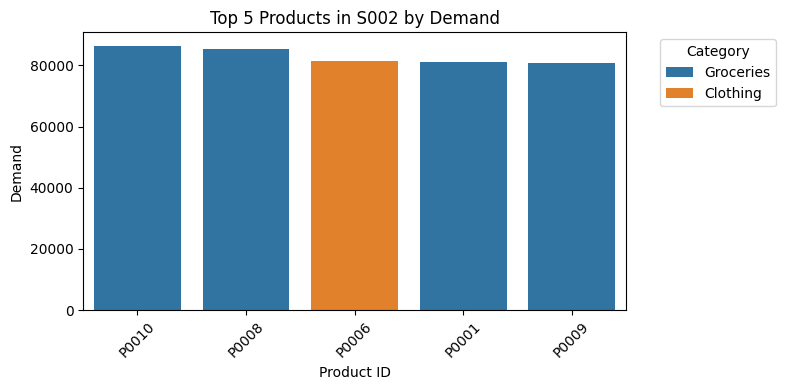

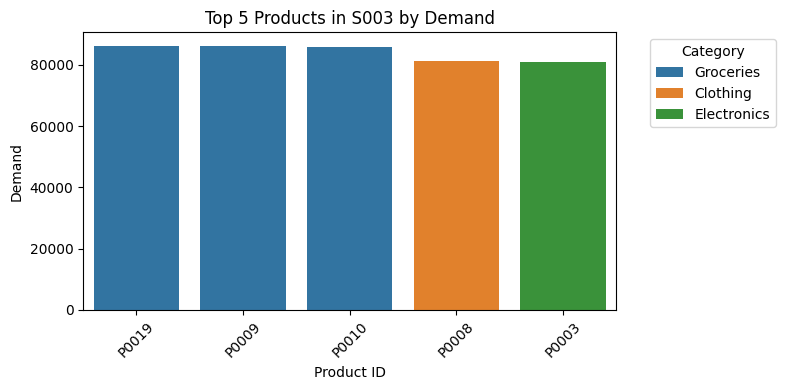

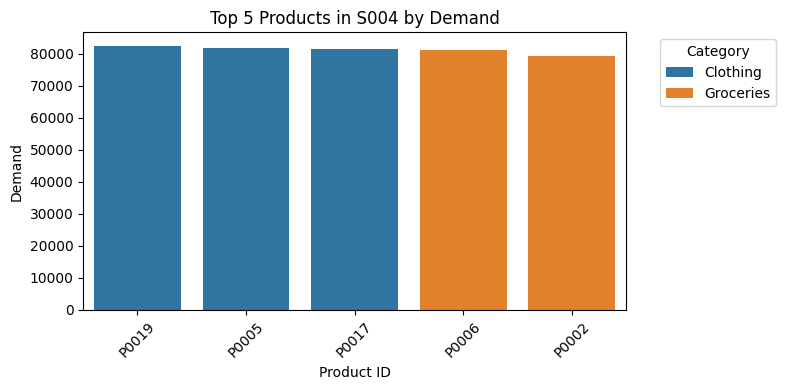

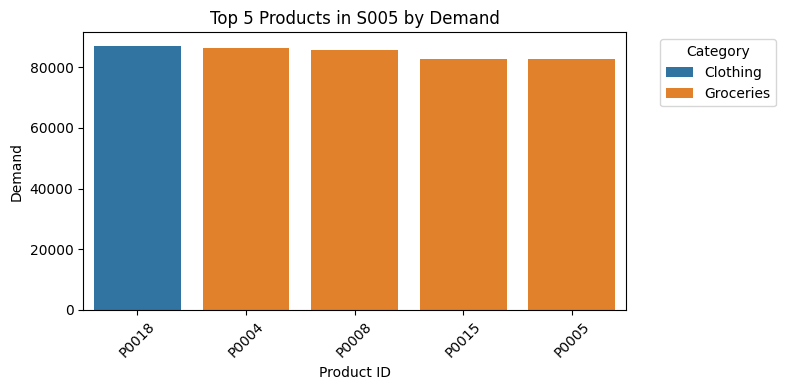

In [65]:
for store_id in df['Store ID'].unique():
    top_products = demand_by_store_by_category_by_product[demand_by_store_by_category_by_product['Store ID'] == store_id]
    top_products = top_products.sort_values('Demand', ascending=False).head()

    plt.figure(figsize=(8,4))
    sns.barplot(data=top_products, x='Product ID', y='Demand', hue='Category', dodge=False)
    plt.title(f"Top 5 Products in {store_id} by Demand")
    plt.legend(title='Category',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### Demand Across Years

In [48]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
demand_by_year = df.groupby('Year')['Demand'].sum().reset_index()
demand_by_year = demand_by_year[demand_by_year['Year'] != 2024]
demand_by_year

,Year,Demand
0,2022,3451546
1,2023,3365174


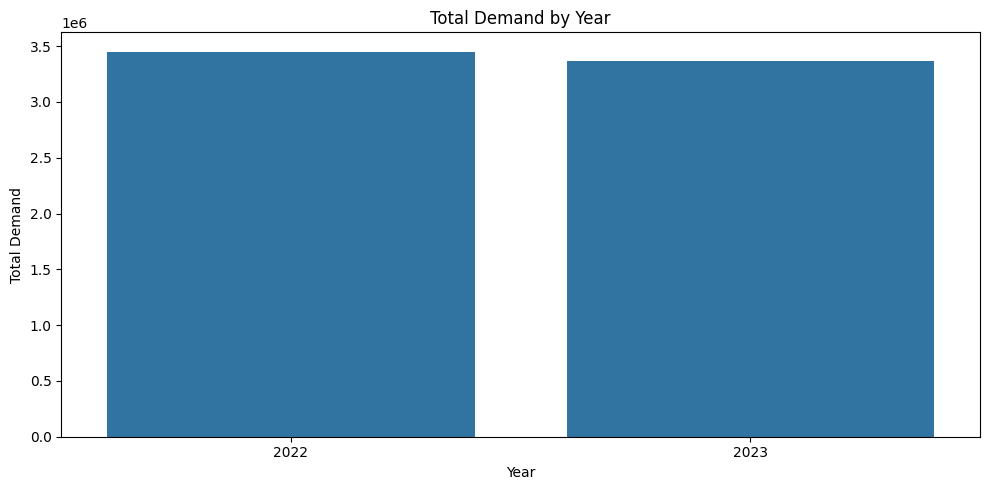

In [49]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_year, x='Year', y='Demand')

plt.title('Total Demand by Year')
plt.xlabel('Year')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

Since Jan is present for all 3 years we compare the first month

In [53]:
df['Month'] = df['Date'].dt.month
demandJan=df[df['Month']==1].groupby('Year')['Demand'].sum().reset_index().sort_values(by='Demand')

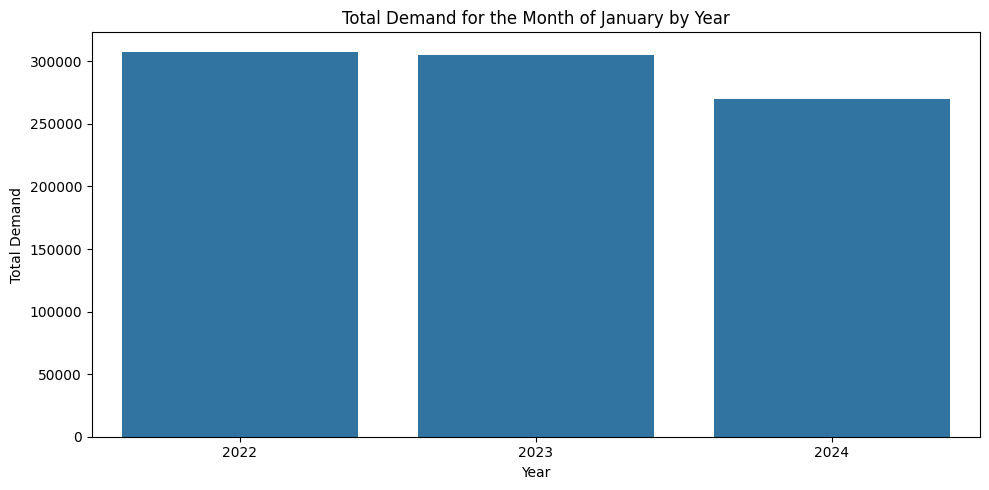

In [54]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demandJan, x='Year', y='Demand')

plt.title('Total Demand for the Month of January by Year')
plt.xlabel('Year')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

#### Region Wise Distribution of Demand

In [57]:
demand_by_region=df.groupby('Region')['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_region

,Region,Demand
3,West,1362271
0,East,1423193
2,South,1461316
1,North,2840230


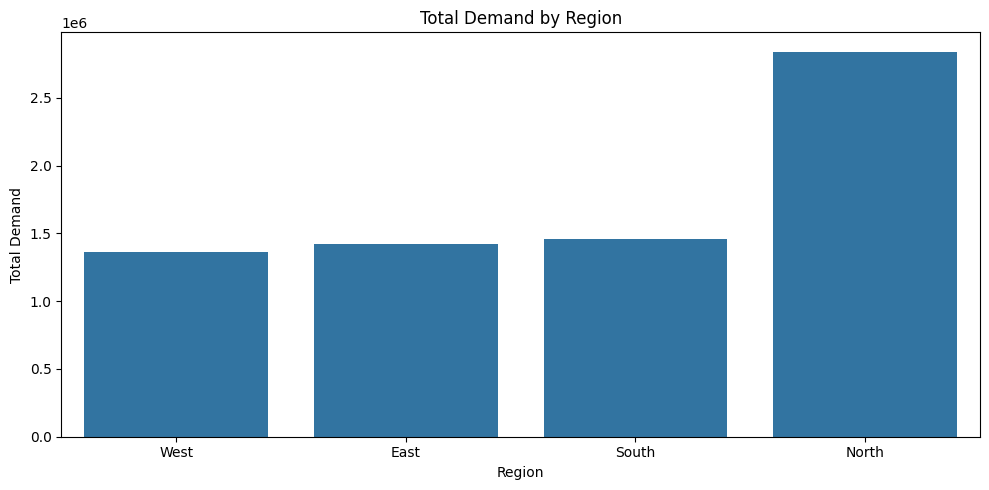

In [58]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_region, x='Region', y='Demand')

plt.title('Total Demand by Region')
plt.xlabel('Region')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

North has the most demand of products

#### Region Wise Category Demand

In [59]:
demand_by_region_by_category=df.groupby(['Region','Category'])['Demand'].sum().reset_index()
demand_by_region_by_category.head(5)

,Region,Category,Demand
0,East,Clothing,147568
1,East,Electronics,235145
2,East,Furniture,163652
3,East,Groceries,679986
4,East,Toys,196842


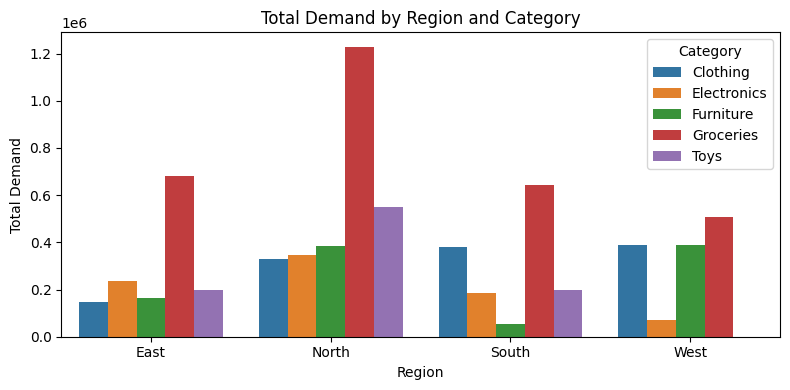

In [60]:
plt.figure(figsize=(8,4))
sns.barplot(data=demand_by_region_by_category,x='Region',hue='Category',y='Demand')

plt.title('Total Demand by Region and Category')
plt.xlabel('Region')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

#### Region Wise Category Product Demand

In [ ]:
demand_by_region_by_category_by_product=df.groupby(['Region','Category','Product ID'])['Demand'].sum().reset_index()
demand_by_region_by_category_by_product.head(5)

,Region,Category,Product ID,Demand
0,East,Clothing,P0008,81349
1,East,Clothing,P0020,66219
2,East,Electronics,P0003,81064
3,East,Electronics,P0011,78083
4,East,Electronics,P0016,75998


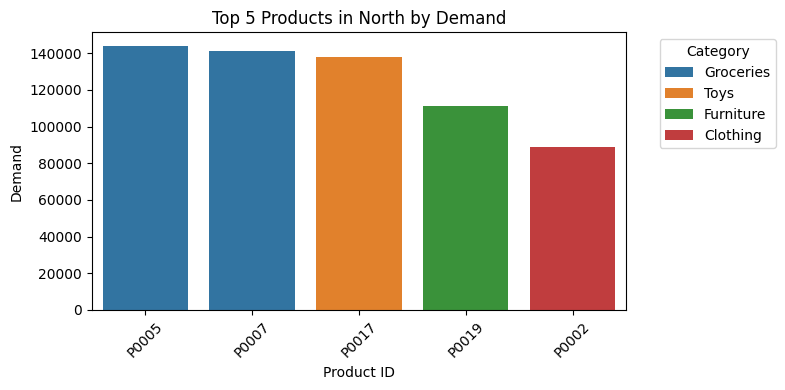

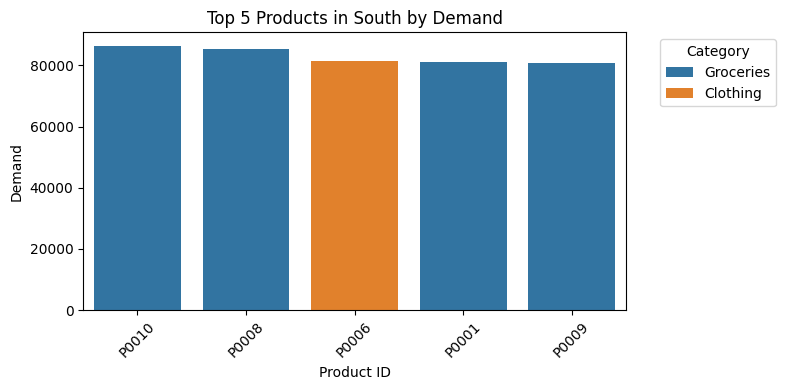

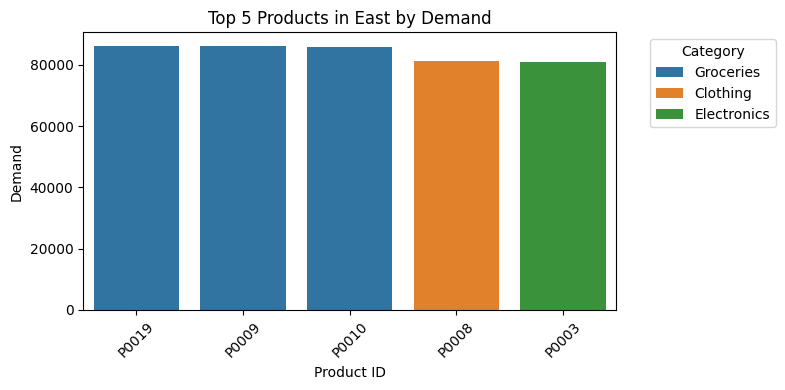

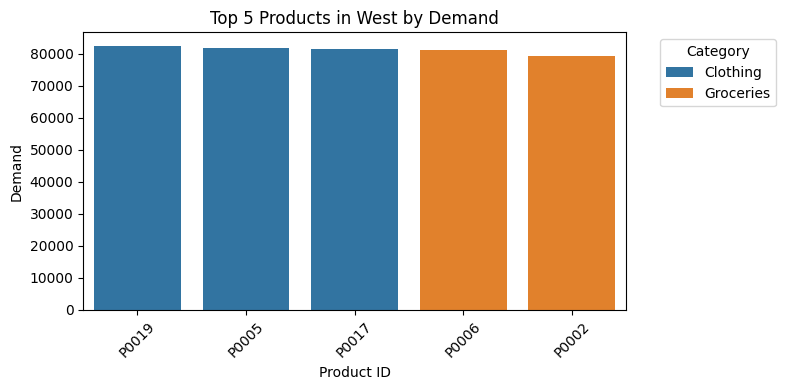

In [68]:
for region in df['Region'].unique():
    top_products = demand_by_region_by_category_by_product[demand_by_region_by_category_by_product['Region'] == region]
    top_products = top_products.sort_values('Demand', ascending=False).head()

    plt.figure(figsize=(8,4))
    sns.barplot(data=top_products, x='Product ID', y='Demand', hue='Category', dodge=False)
    plt.title(f"Top 5 Products in {region} by Demand")
    plt.legend(title='Category',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


All sorts of products are in demand in the north region.

#### Weather vs Demand

In [77]:
demand_by_weather=df.groupby('Weather Condition')['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_weather.head()

,Weather Condition,Demand
2,Snowy,979307
1,Rainy,1525961
3,Sunny,2284228
0,Cloudy,2297514


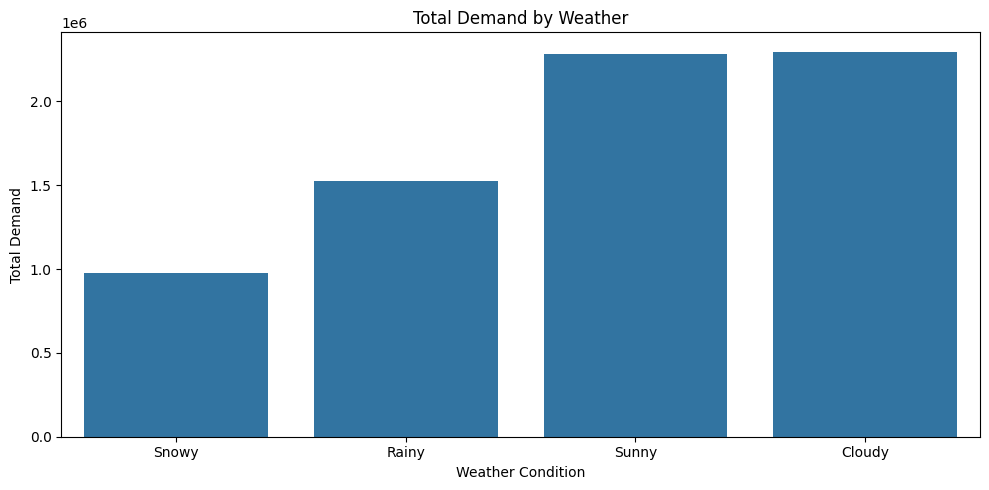

In [104]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_weather, x='Weather Condition', y='Demand')

plt.title('Total Demand by Weather')
plt.xlabel('Weather Condition')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

This plot does make sense as in rainy and snowy weather it's hard to travel. Thus sunny and cloudy weather sees more demand.

#### Promotion vs Demand

In [84]:
demand_by_promotion=df.groupby('Promotion')['Demand'].count().reset_index().sort_values(by='Demand')
demand_by_promotion.head()

,Promotion,Demand
1,1,22427
0,0,48228


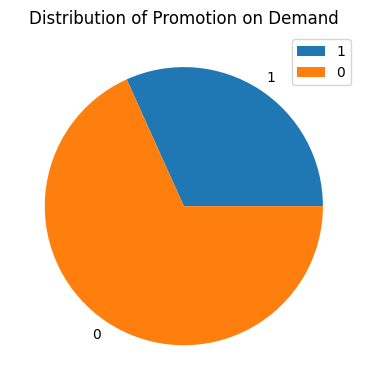

In [85]:
plt.figure(figsize=(10,4))
plt.pie(x=demand_by_promotion['Demand'],labels=demand_by_promotion['Promotion'])
plt.legend()
plt.title('Distribution of Promotion on Demand')
plt.tight_layout()
plt.show()

#### Epidemic vs Demand

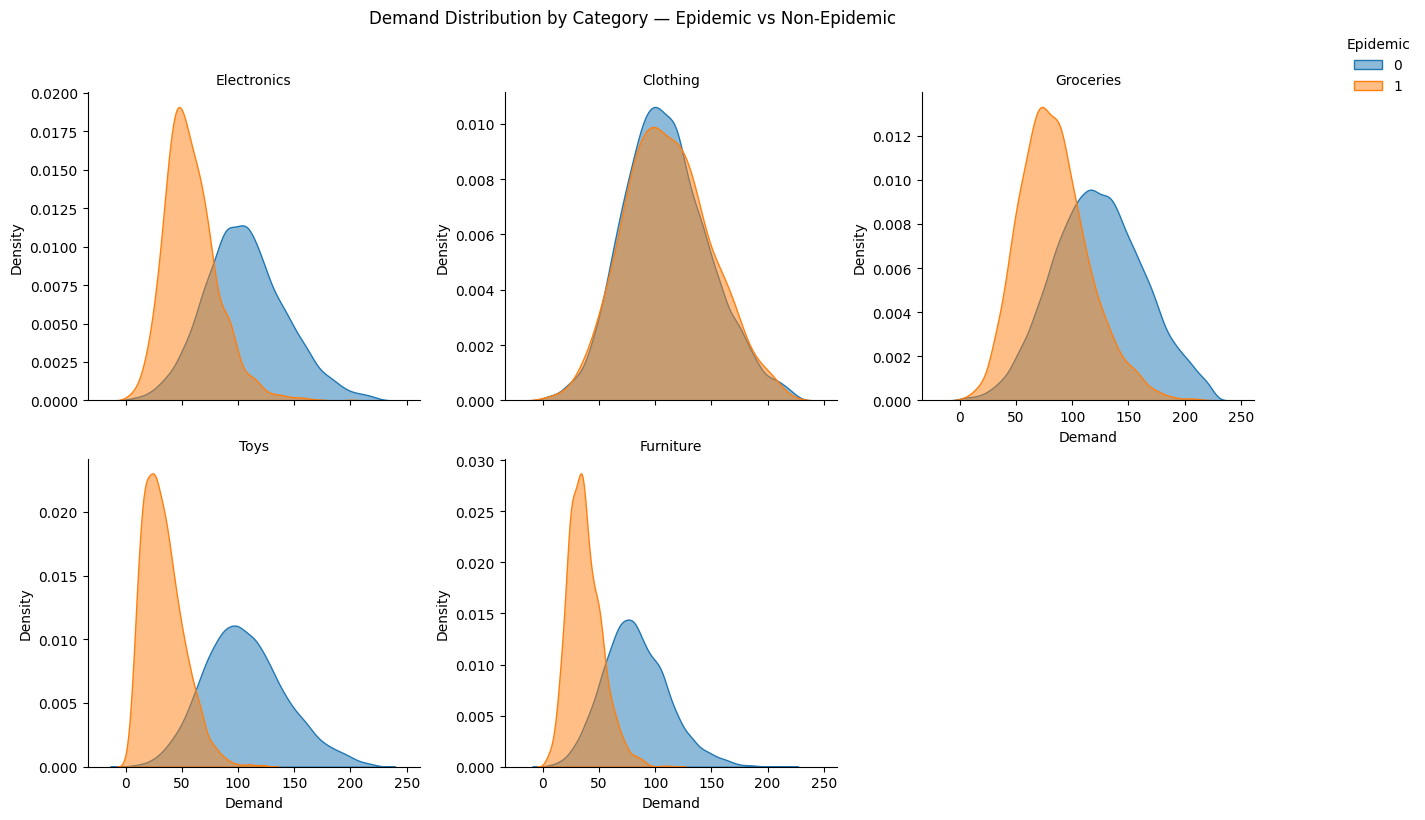

In [97]:
g = sns.FacetGrid(df, col='Category', hue='Epidemic', col_wrap=3, sharey=False, height=4)
g.map(sns.kdeplot, 'Demand', fill=True, alpha=0.5)
g.add_legend(title='Epidemic',bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Demand Distribution by Category — Epidemic vs Non-Epidemic", y=1.02)
plt.tight_layout()
plt.show()

The demand for clothing remained almost consistent epidemic times while all the categories suffered.

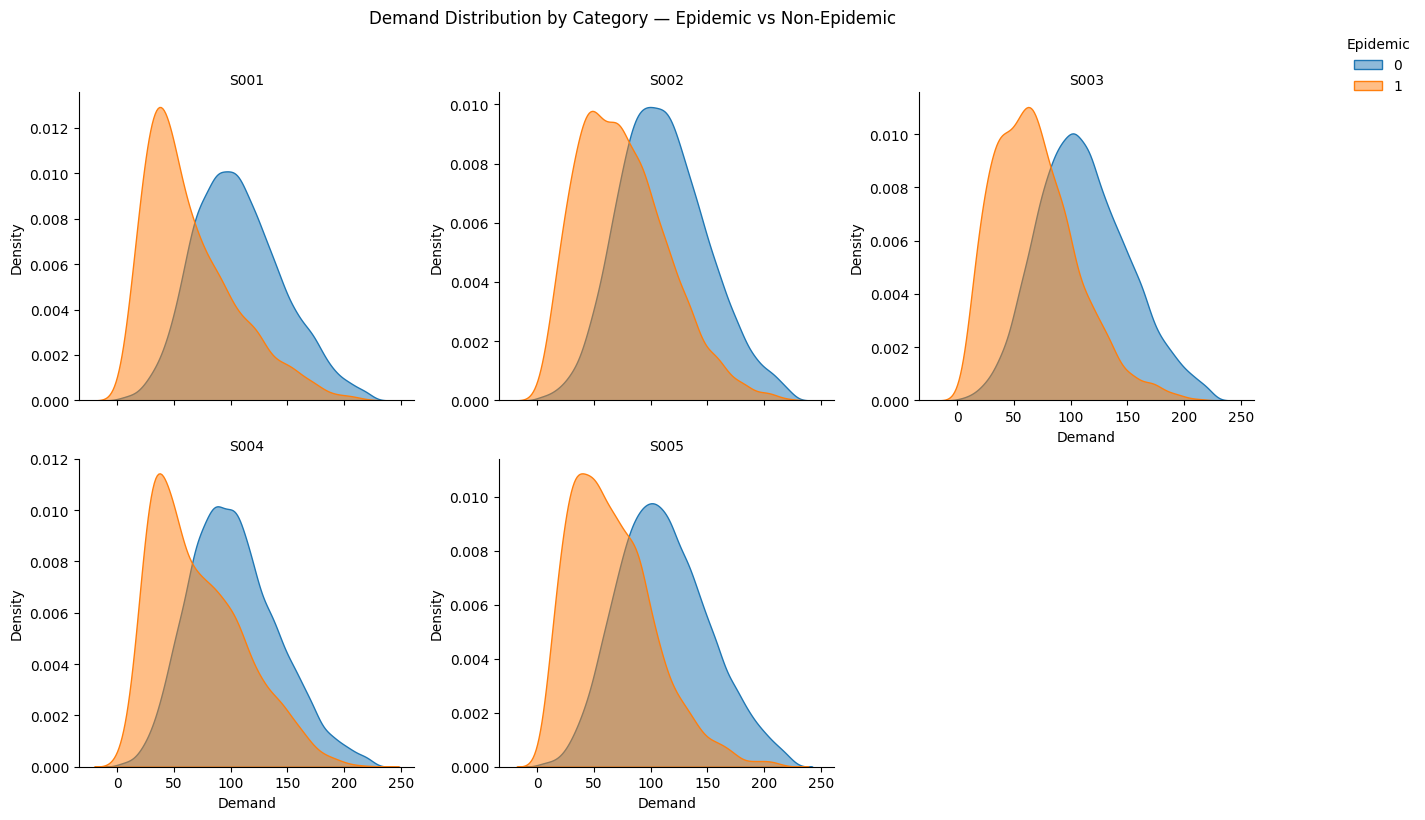

In [98]:
g = sns.FacetGrid(df, col='Store ID', hue='Epidemic', col_wrap=3, sharey=False, height=4)
g.map(sns.kdeplot, 'Demand', fill=True, alpha=0.5)
g.add_legend(title='Epidemic',bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Demand Distribution by Category — Epidemic vs Non-Epidemic", y=1.02)
plt.tight_layout()
plt.show()

S002 suffered the least during epidemic time.

### Seasonality

####  vs Weather Condition Correlation

In [102]:
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
df['Seasonality_num'] = df['Seasonality'].map(season_map)

weather_map = {'Snowy': 0, 'Cloudy': 1, 'Rainy': 2, 'Sunny': 3}
df['Weather_num'] = df['Weather Condition'].map(weather_map)


In [103]:
correlation = df['Seasonality_num'].corr(df['Weather_num'])
print(f"Correlation between Seasonality and Weather Condition: {correlation:.3f}")

Correlation between Seasonality and Weather Condition: 0.093


The 2  features are not correlated

 #### vs Demand

In [105]:
demand_by_season=df.groupby('Seasonality')['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_season.head()

,Seasonality,Demand
1,Spring,1651147
0,Autumn,1731120
2,Summer,1737824
3,Winter,1966919


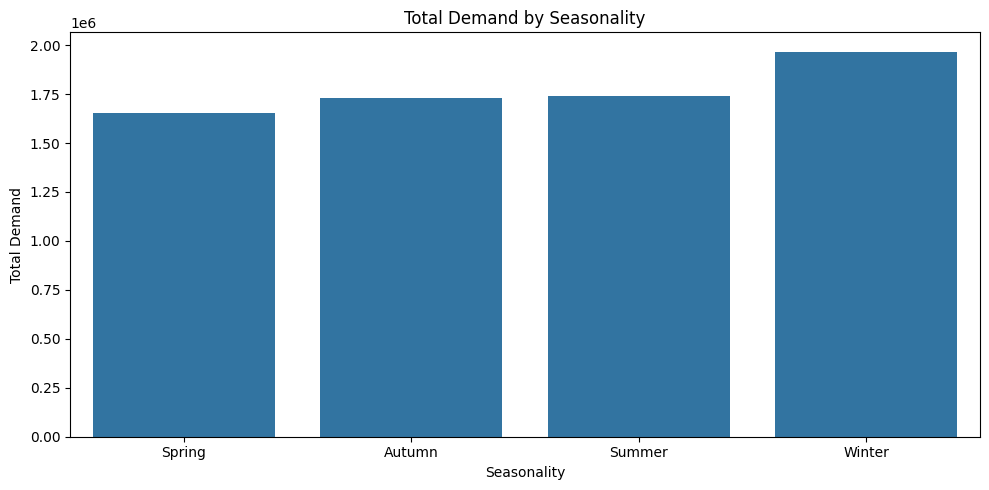

In [106]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_season, x='Seasonality', y='Demand')

plt.title('Total Demand by Seasonality')
plt.xlabel('Seasonality')
plt.ylabel('Total Demand')
plt.tight_layout()
plt.show()

In [108]:
demand_by_season_by_category=df.groupby(['Seasonality','Category'])['Demand'].sum().reset_index().sort_values(by='Demand')
demand_by_season_by_category.head()

,Seasonality,Category,Demand
6,Spring,Electronics,190465
1,Autumn,Electronics,205872
11,Summer,Electronics,212477
7,Spring,Furniture,222893
9,Spring,Toys,224470


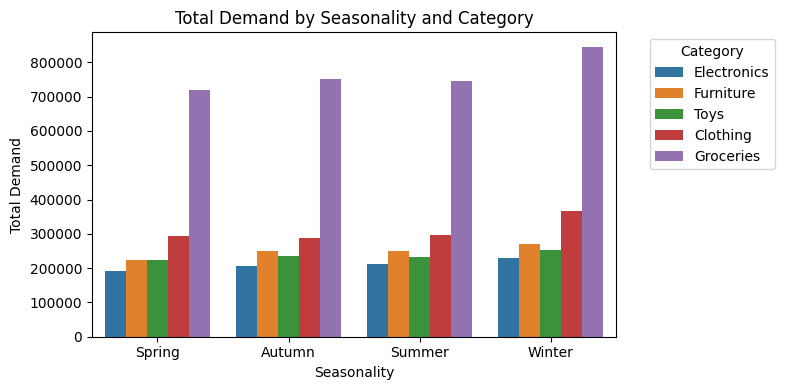

In [110]:
plt.figure(figsize=(8,4))
sns.barplot(data=demand_by_season_by_category,x='Seasonality',hue='Category',y='Demand')

plt.title('Total Demand by Seasonality and Category')
plt.xlabel('Seasonality')
plt.ylabel('Total Demand')
plt.legend(title='Category',bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

In [114]:
demand_by_season_by_store=df.groupby(['Seasonality','Store ID'])['Demand'].sum().reset_index()
demand_by_season_by_store.head()

,Seasonality,Store ID,Demand
0,Autumn,S001,336717
1,Autumn,S002,350684
2,Autumn,S003,350010
3,Autumn,S004,333243
4,Autumn,S005,360466


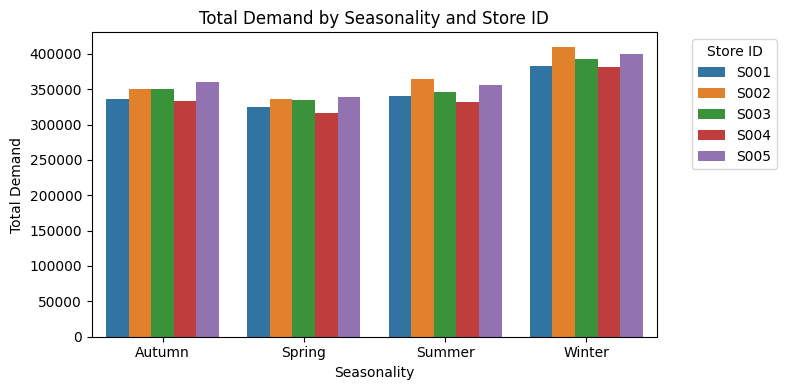

In [115]:
plt.figure(figsize=(8,4))
sns.barplot(data=demand_by_season_by_store,x='Seasonality',hue='Store ID',y='Demand')

plt.title('Total Demand by Seasonality and Store ID')
plt.xlabel('Seasonality')
plt.ylabel('Total Demand')
plt.legend(title='Store ID',bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

### Units Sold vs Units Ordered vs Inventory Level

In [119]:
store_summary

,Store ID,Inventory Level,Units Sold,Units Ordered
0,S001,3408726,1173636,1165490
1,S002,4255441,1237799,1223018
2,S003,3903038,1200748,1193222
3,S004,3610044,1156961,1145190
4,S005,3696070,1226517,1191287


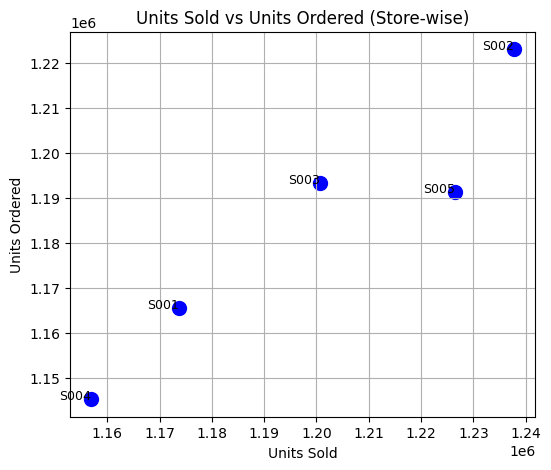

In [120]:
plt.figure(figsize=(6, 5))
plt.scatter(store_summary['Units Sold'], store_summary['Units Ordered'], s=100, color='blue')
for i, row in store_summary.iterrows():
    plt.text(row['Units Sold'], row['Units Ordered'], row['Store ID'], fontsize=9, ha='right')
plt.xlabel("Units Sold")
plt.ylabel("Units Ordered")
plt.title("Units Sold vs Units Ordered (Store-wise)")
plt.grid(True)
plt.show()

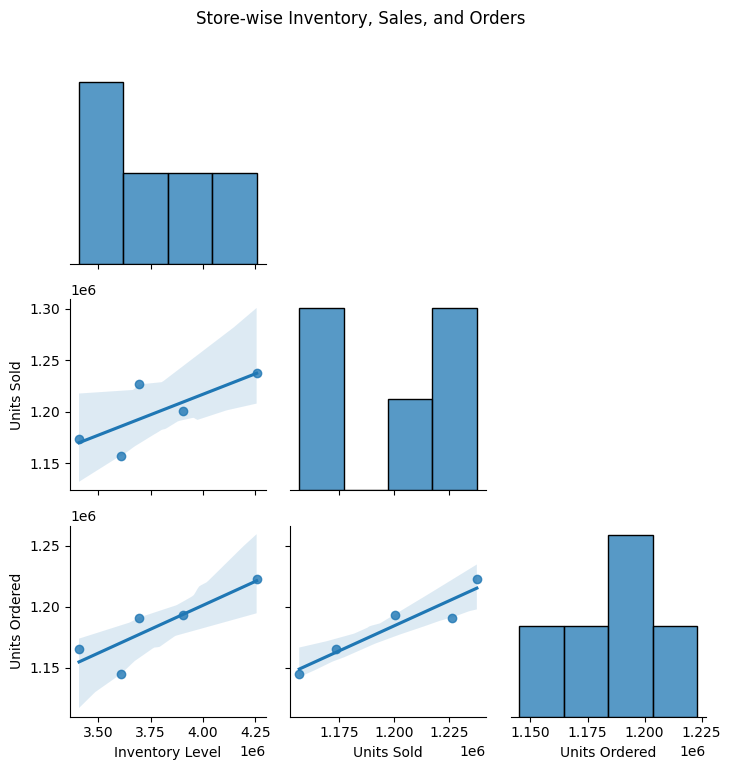

In [118]:
store_summary = df.groupby('Store ID')[['Inventory Level', 'Units Sold', 'Units Ordered']].sum().reset_index()

# Pairplot on grouped data
sns.pairplot(store_summary[['Inventory Level', 'Units Sold', 'Units Ordered']], kind='reg', corner=True)
plt.suptitle("Store-wise Inventory, Sales, and Orders", y=1.02)
plt.tight_layout()
plt.show()


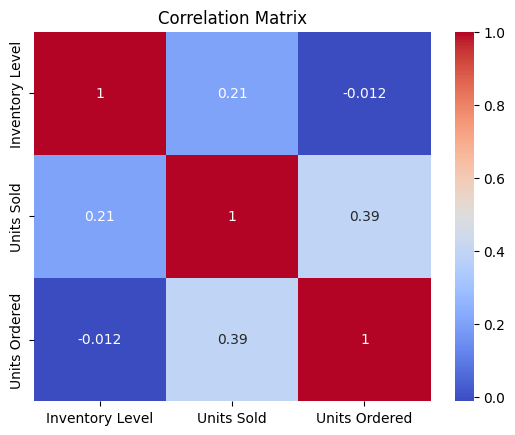

In [117]:
corr = df[['Inventory Level', 'Units Sold', 'Units Ordered']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Units Sold and Ordered are correlated to some extent.

### Discount vs Category

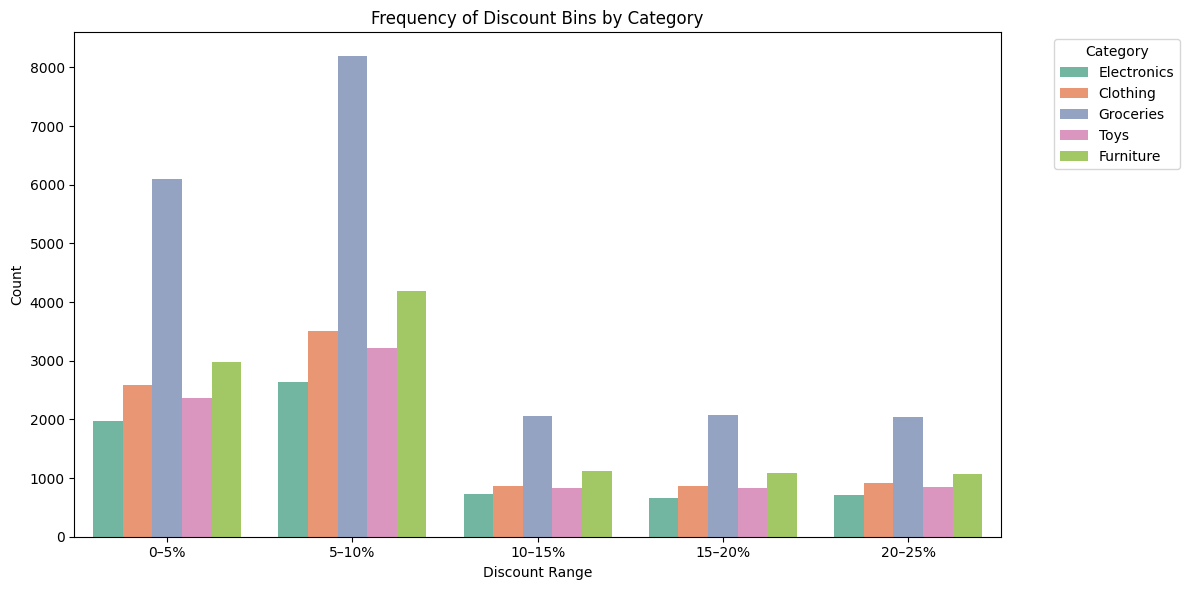

In [74]:
df['Discount Bin'] = pd.cut(df['Discount'], bins=[0, 5, 10, 15, 20, 25],
                            labels=['0–5%', '5–10%', '10–15%', '15–20%', '20–25%'])

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Discount Bin', hue='Category', palette='Set2')

plt.title('Frequency of Discount Bins by Category')
plt.xlabel('Discount Range')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Groceries have the highest discount amongst all categories which might explain its highest demand with such a significant difference.

### Discount vs Region

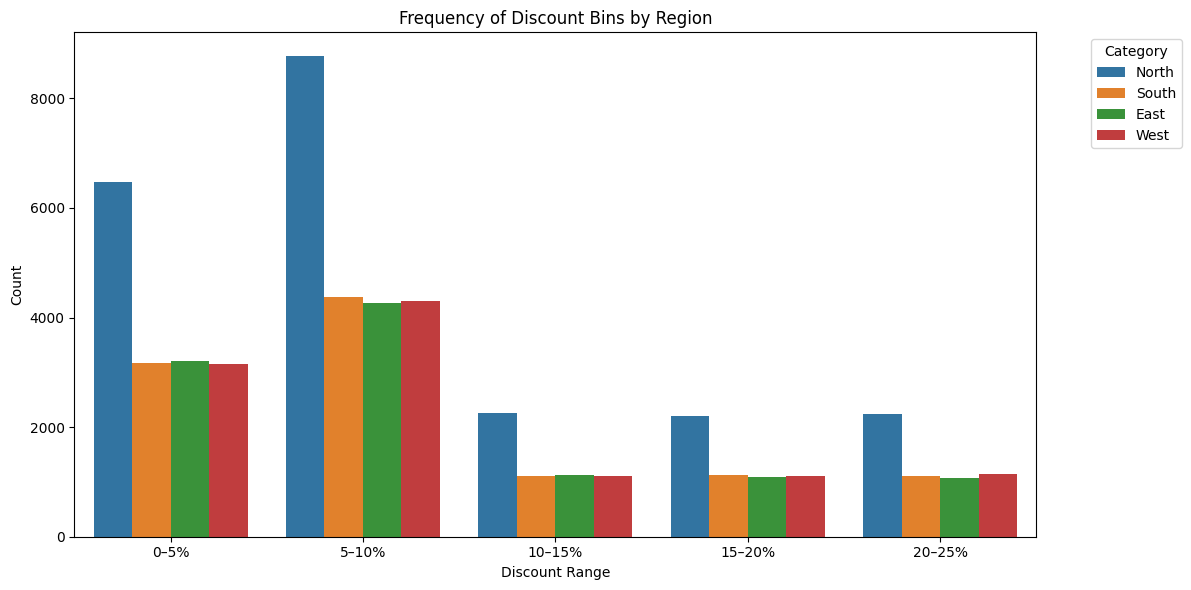

In [75]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Discount Bin', hue='Region')

plt.title('Frequency of Discount Bins by Region')
plt.xlabel('Discount Range')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

North has highest amount of discount which might explain most demand in this region.

### Competitor Price and Our Price vs Demand

In [121]:
category_price_demand = df.groupby('Category')[['Price', 'Competitor Pricing', 'Demand']].agg({
    'Price': 'mean',
    'Competitor Pricing': 'mean',
    'Demand': 'sum'
}).reset_index()

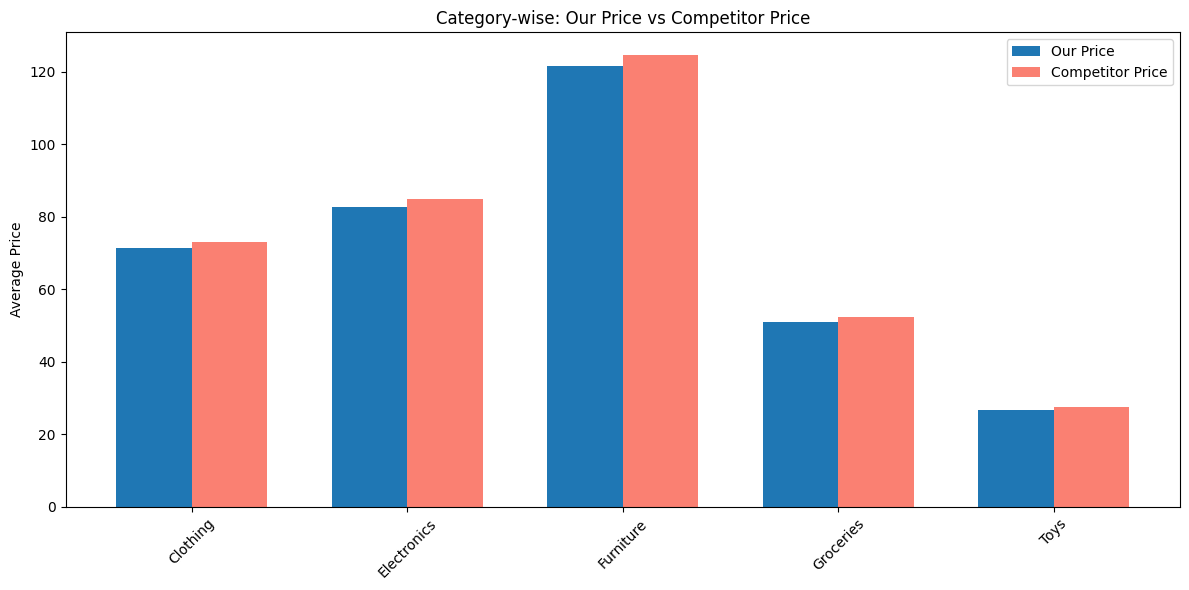

In [123]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(category_price_demand))

plt.bar(x, category_price_demand['Price'], width=bar_width, label='Our Price')
plt.bar([i + bar_width for i in x], category_price_demand['Competitor Pricing'], width=bar_width, label='Competitor Price', color='salmon')

plt.xticks([i + bar_width / 2 for i in x], category_price_demand['Category'], rotation=45)
plt.ylabel('Average Price')
plt.title('Category-wise: Our Price vs Competitor Price')
plt.legend()
plt.tight_layout()
plt.show()

We sell products on a more affordable rate.

## Feature Engineering

### Time of Year

In [124]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

### Price Gap

In [125]:
df['Price_Diff'] = df['Price'] - df['Competitor Pricing']
df['Price_Ratio'] = df['Price'] / df['Competitor Pricing']

### Inventory Management Efficiency

In [159]:
df['Sell_Through_Rate'] = df['Units Sold'] / (df['Inventory Level'] + 1)
df['Order_to_Sales_Ratio'] = df['Units Ordered'] / (df['Units Sold'] + 1)

### One hot encoding

In [139]:
df.drop(columns='Discount Bin',inplace=True)

In [140]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features:", categorical_cols)

Categorical Features: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']


In [142]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 

## Modeling

In [166]:
target = 'Demand'

features = df.drop(columns=['Date', 'Demand']) 

X = features
y = df[target]

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [169]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 15.98
R² Score: 0.86


C:\Users\A06BH\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


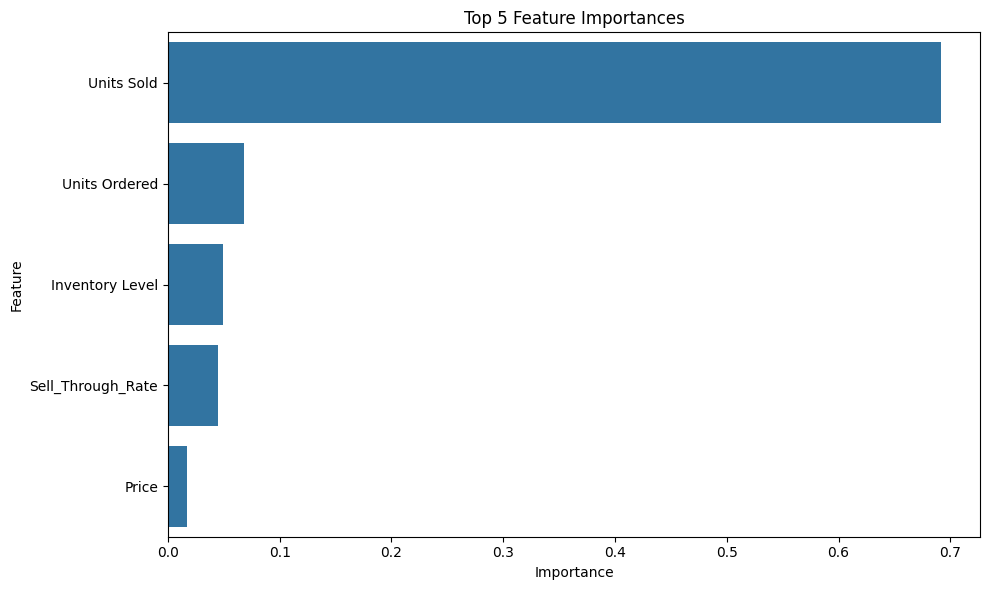

In [171]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:5], y=feat_imp.index[:5])
plt.title("Top 5 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
